In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [124]:
import sys, os, time, re
import numpy as np
import pickle
import copy as cp
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
from multiprocessing import Pool
import matplotlib as m
import scipy as sp
m.rcParams.update({'font.size': 14})

from catwoman.shelter import Cat
from alfred.parameters import *

In [3]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Comparison of Emulators

## Introduction
In this notebook, we investigate how well both emulators (RF and NN) do with overall accuracy and also how well they interpolate to regions of parameter space that are not sampled in the original LoReLi dataset.

In [4]:
CL = 95
percentile1=(100-CL)/2
percentile2=CL+(100-CL)/2
smoothing = 3.

## Model parameter set

Here we import, and format the dataset. 

In [5]:
#home_dir = '/home/emc-brid'
home_dir = '/Users/emcbride'
nells = 30

In [6]:
def get_sims(nells, dir=f'{home_dir}/spectra/kSZ/LoReLi'):
    sims = []
    for filename in os.listdir(f'{dir}/nells{nells}'):
        #files_LoReLi.append(filename)
        match = re.search(r'\d{5}', filename)
        sims.append(match.group())
    
    print(f'{len(sims)} sims available')

    return sims

In [44]:
sims = get_sims(nells)
#sims_100 = get_sims(100)

6333 sims available


In [ ]:
# np.save('check_this_set', sims)

In [33]:
np.save('failed_reion', failed_reion)

In [47]:
len(failed_reion)

1212

In [46]:
# #lowNz = np.load('sims_smallN_z.npy')
wrong_fesc = np.load(f'{home_dir}/alfred/notebooks/fesc_p200_sims.npy')
checked_sims = list(np.load(f'{home_dir}/alfred/notebooks/check_this_set.npy'))
failed_reion = list(np.load(f'{home_dir}/alfred//failed_reion.npy'))

df = pd.read_pickle(f'{home_dir}/kSZ/data/LoReLi_summaries/LoReLi_clean')
df = df.loc[sims]
#df = df.drop(lowNz)
df = df.drop(wrong_fesc, errors='ignore')
df = df.drop(failed_reion, errors='ignore')

df

,Xray_Lfunc,hard_Xray_fraction,gasconversion_timescale,log10_Mmin,ion_escapefrac_post
sim_n,,,,,
17038,0.000614,0.0,1998.1,9.60,0.500
10757,0.006067,0.2,2427.3,8.53,0.275
11449,0.002822,0.6,2493.8,9.07,0.275
16326,0.000288,0.4,1182.7,9.07,0.050
12140,0.001306,0.8,1215.1,9.60,0.275
...,...,...,...,...,...
14528,0.000192,0.8,3991.4,8.53,0.050
12159,0.004128,1.0,1215.1,9.60,0.275
11450,0.002822,0.8,2493.8,9.07,0.275


Still working, on the 0th sim out of 5103 available, sim 17038...
Still working, on the 500th sim out of 5103 available, sim 12744...
Still working, on the 1000th sim out of 5103 available, sim 12421...
Still working, on the 1500th sim out of 5103 available, sim 11991...
Still working, on the 2000th sim out of 5103 available, sim 17539...
Still working, on the 2500th sim out of 5103 available, sim 17315...
Still working, on the 3000th sim out of 5103 available, sim 13633...
Still working, on the 3500th sim out of 5103 available, sim 14038...
Still working, on the 4000th sim out of 5103 available, sim 10399...
Still working, on the 4500th sim out of 5103 available, sim 13251...
Still working, on the 5000th sim out of 5103 available, sim 13119...
Still working, on the 0th sim out of 5103 available, sim 17038...
Still working, on the 500th sim out of 5103 available, sim 12744...
Still working, on the 1000th sim out of 5103 available, sim 12421...
Still working, on the 1500th sim out of 51

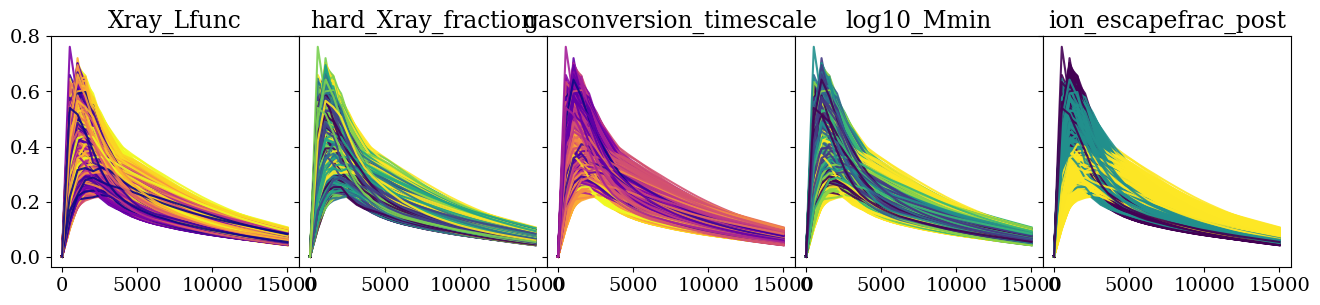

In [36]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(16,3))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

params_to_regress = astro_labels # currently just all

baddies = []
failed_reion = []
for i, pname in enumerate(params_to_regress):
    if (pname == params_to_regress[0]) or (pname == params_to_regress[2]):
        norm = matplotlib.colors.LogNorm(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('plasma') 
    else:   
        norm = matplotlib.colors.Normalize(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('viridis_r')

    # legend_handles = []
    fesc_vals = df[params_to_regress[-1]].unique()
    for j, sn in enumerate(df.index.to_list()):
        # # if df.loc[sn][params_to_regress[-1]] == fesc_vals[0]:
        #     axes = ax[0]
        # if df.loc[sn][params_to_regress[-1]] == fesc_vals[1]:
        #     axes = ax[1]
        # if df.loc[sn][params_to_regress[-1]] == fesc_vals[2]:
        #     axes = ax[2]
        #fn_G = f'/home/emc-brid/spectra/kSZ/Gorce/kSZ_Gorce_simu{sn}.npz'

        if j % 500 == 0:
            print(f'Still working, on the {j}th sim out of {len(df.index.to_list())} available, sim {sn}...')
            
        # if i == 0:
        #    # if sn not in checked_sims:
        #     sim =  Cat(sn,
        #             #   verbose=True,
        #                 path_sim=f'{home_dir}/ps_ee',
        #             #    path_spectra=f'{home_dir}/spectra/Pee',
        #                 path_ion=f'{home_dir}/kSZ/data/LoReLi_summaries/ion_histories_full.npz',
        #                 path_params=f'{home_dir}/kSZ/data/LoReLi_summaries/param_files', LoReLi_format=True)

        #     if np.max(sim.xe) < .8:
        #         failed_reion.append(sn)


        fn_L = f'{home_dir}/spectra/kSZ/LoReLi/nells{nells}/kSZ_LoReLi_simu{sn}.npz'
        
       # Gorce = np.load(fn_G)
        LoReLi = np.load(fn_L)
  
        # if np.max(LoReLi['kSZ']) > 1.0:
        #     if i == 0:
        #         print(f'Take a look at simu{sn}!')
        #         baddies.append(sn)
        #     continue

        # if np.max(LoReLi['kSZ']) < .01:
        #     if i == 0:
        #         print(f'Take a look at simu{sn}!')
        #         baddies.append(sn)
        #     continue
            
        #ax[0,i].plot(Gorce['ells'], Gorce['kSZ'], color=cmap(norm(df.loc[sn][pname])))
        ax[i].plot(LoReLi['ells'], LoReLi['kSZ'], color=cmap(norm(df.loc[sn][pname])), alpha=.9)
    
        # if np.isclose(df.loc[sn][pname], unique).any():
        #     label = f"Value: {df.loc[sn][pname]:.5f}"
        #     legend_handles.append(plt.Line2D([0], [0], color=cmap(norm(df.loc[sn][pname])), label=label))
  #  ax[i].axhline(.5, color='gray')
    # ax[i].legend(handles=legend_handles, title="Legend")

    ax[i].set_title(astro_labels[i])

In [ ]:
# fesc_vals
# df = df[df[astro_labels[-1]] == fesc_vals[1]]

In [37]:
# parameters of the model
labels = astro_pnames_formatted[:]
paramnames = astro_pnames[:]
theta_ref = df[astro_labels].mean().to_list()[:] # mean values
ndim = len(theta_ref)

Distribution of model parameters

In [149]:
# # shape is (ndim, nsamples)
# df = df.loc[sims]

# if nells == 100:
#     df = df.drop(baddies)

# df = df.drop(lowNz)
# df = df.drop(wrong_fesc, errors='ignore')

params = df[astro_labels].to_numpy()
print(params.shape)
for i in range(len(params[0])):
    print('%.4f < %s < %.4f' %(np.min(params[:,i]),paramnames[i],np.max(params[:,i])))
    print(f'with mean {paramnames[i]}={means[i]:.4f}')
    print()

(5103, 5)
0.0002 < L_X < 0.0192
with mean L_X=0.0047

0.0000 < f_X < 1.0000
with mean f_X=0.5021

738.9000 < tau < 10504.7000
with mean tau=3148.9454

8.0000 < Mmin < 9.6000
with mean Mmin=8.7886

0.0500 < f_esc < 0.5000
with mean f_esc=0.2362



## Regression

In [53]:
np.where(np.isin(astro_labels, astro_labels[1:3]))[0]

array([1, 2])

In [77]:
params[:,np.where(np.isin(astro_labels, astro_labels[1:3]))[0]].shape

(5103, 2)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [42]:
np.where(astro_labels == params_to_regress[0)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2309285669.py, line 1)

In [43]:
astro_labels == params_to_regress

True

### Training set

In [ ]:
rf = RandomForest(df, {}, params_to_regress)
X_train, X_test, y_train, y_test = rf.prep_data()
rf.regress(X_train, X_test, y_train, y_test)
y_pred = rf.prediction(X_test)
rf.fancy_plot(y_test, y_pred)

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3906350/3784208834.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell^{kSZ}$', fontsize='x-large')
/tmp/ipykernel_3906350/3784208834.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Multipole $\ell$')


Text(0.5, 0, 'Multipole $\\ell$')

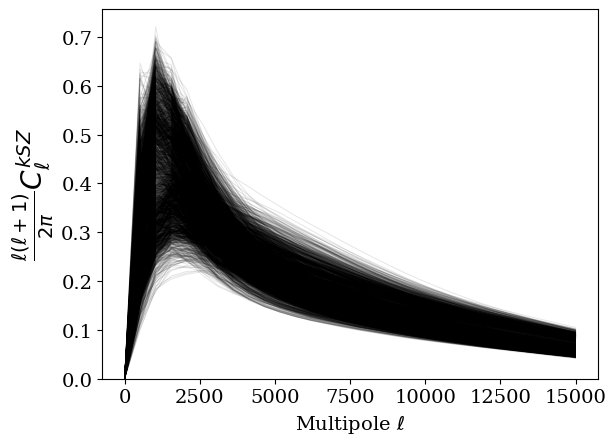

In [ ]:
plt.figure()
plt.plot(ells, pksz.T, lw=.7, color='k', alpha=.1)
plt.ylim(bottom=0.)
plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell^{kSZ}$', fontsize='x-large')
plt.xlabel('Multipole $\ell$')

### RF training setup

### NN training setup

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # This disables GPU usage

In [14]:
# Define the neural network model

hyperparameters_NN = {}

In [ ]:
# Generate some example data (you can replace this with your own data)
# Example: Predict y = 2x + 1 with some noise
# X = np.linspace(0, 10, 1000).reshape(-1, 1)
# y = 2 * X + 1 + np.random.normal(0, 1, X.shape[0]).reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(params.T, pksz, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)

input_shape = X_train.shape[1:]
print(input_shape)

(5,)


In [ ]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((2188, 5), (547, 5), (2188, 30), (547, 30))

In [ ]:
y_pred.shape, y_test.shape

((667, 30), (547, 30))

In [ ]:
pa

(547, 5)

In [ ]:
#np.save('ells_for_regressor', ells)

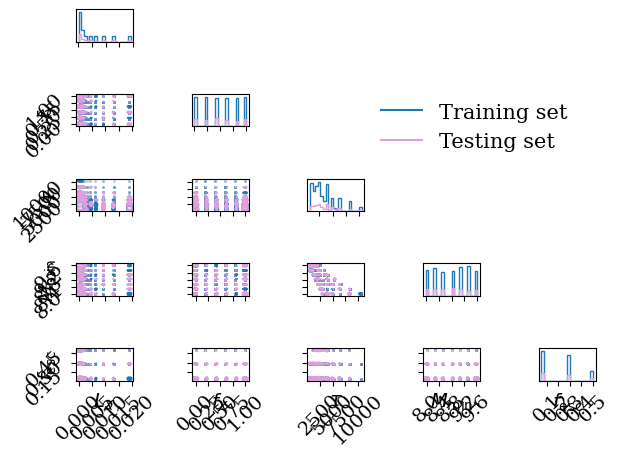

In [ ]:
colors = ['#1f77b4','plum','gold']
cmaps = ['Blues','PuRd','Wistia']
datasets = ['Training set', 'Testing set']
fig, axes = plt.subplots(len(params),len(params))
for i in range(len(datasets)):
    axes[-1,-1].plot([],[],label=datasets[i],color=colors[i])

corner.corner(X_train,color=colors[0],labels=labels,cmap=cmaps[0],fig=fig)
corner.corner(X_test,color=colors[1],labels=labels,cmap=cmaps[1],fig=fig,alpha=.5)

fig.legend(loc=(0.6,0.65),frameon=False,fontsize=15)
fig.tight_layout()
# fig.savefig('Training_testing_sets_%s.png' %seed)

In [ ]:
# # Suggestion from ChatGPT (Yes, I know LA is burning!)
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# rf = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)


In [ ]:
#mean absolute error per l bin
MAE = np.mean(np.abs(y_test-y_pred),axis=0)
#root mean squared error per l bin
RMSE = np.sqrt(np.sum((y_test-y_pred)**2,axis=0)/y_test.shape[0])

RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate

In [ ]:
err = np.std(np.abs(y_test-y_pred),axis=0)
ratio = y_pred/y_test
a68, b68 = np.percentile(ratio,percentile1,axis=0), np.percentile(ratio,percentile2,axis=0)
MAE2 = np.mean(np.abs(ratio-1)*y_pred,axis=0)

(0.0, 0.050512479574094854)

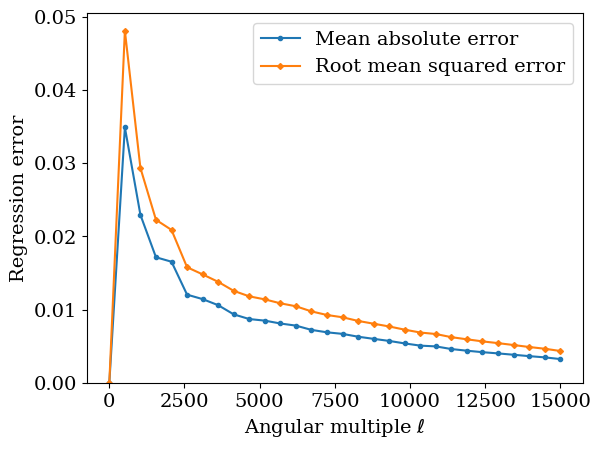

In [ ]:
plt.figure()
plt.plot(ells,MAE,marker='o',markersize=3,label='Mean absolute error')
plt.plot(ells,RMSE,marker='D',markersize=3,label='Root mean squared error')
plt.legend()
plt.xlabel(r'Angular multiple $\ell$')
plt.ylabel(r'Regression error')
plt.ylim(bottom=0)

ValueError: x and y must be the same size

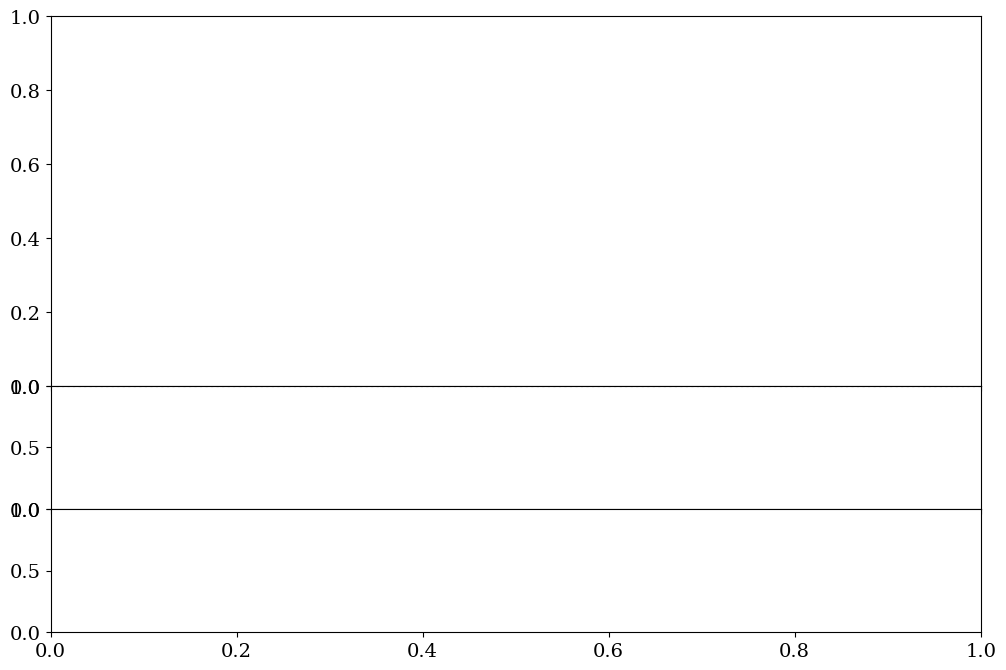

In [ ]:
# plot Cls true and Cls predicted with errors

new_length = 9991
new_xx = np.linspace(1, 15000, 11000)

# pick random subset of 50 parameters among the test set 
subset_indices = np.random.randint(low=0, high=y_test.shape[0], size=50)

fig, axes = plt.subplots(3,1,figsize=(12,8),sharex=True,gridspec_kw={'height_ratios':(3,1,1),'hspace':0})
axes[1].axhline(1,color='k',ls=':')
for i, ind in enumerate(subset_indices):
    color = np.take(colors, i, mode='wrap')
    # plot true spectra for parameter set
    # rescale to true amplitudes (without alpha_i)
    ytrue = y_test[ind]
    axes[0].scatter(ells,ytrue, marker="+", color=color, s=30, zorder=2,alpha=.5)
    # plot predicted spectra for parameter set
    yrecons = y_pred[ind]
    # interpolated version to look nice
    new_yy = sp.interpolate.interp1d(ells,y_pred[ind,:] , kind='quadratic', fill_value='extrapolate')(new_xx)
    #new_yy = new_yy*(exponents[0]*np.prod(np.abs(X_test[ind,:]/theta_ref)**exponents[1:]))
    axes[0].plot(new_xx,new_yy, "-", color=color, lw=1., zorder=1,alpha=.5)
    # ratio of pred to true
    axes[1].plot(ells,y_pred[ind,:]/y_test[ind,:],marker='o',color=color,lw=1,markersize=3,alpha=.5)
    # diff between pred and true
    axes[2].plot(ells,ytrue-yrecons,marker='o',color=color,lw=1,markersize=3,alpha=.5)

# uncertainties on ratio
ratio = y_pred/y_test
a68, b68 = np.percentile(ratio,percentile1,axis=0), np.percentile(ratio,percentile2,axis=0)
axes[1].fill_between(ells, b68, a68, color='k',alpha=0.2)
axes[1].plot(ells,np.median(ratio,axis=0),color='k', linestyle='-', linewidth=2)
# uncertainties on difference
ratio2 = (y_test - y_pred)#*(exponents[0]*np.prod(np.abs(X_test/theta_ref)**exponents[1:],axis=1))[:,None]
a682, b682 = np.percentile(ratio2,percentile1,axis=0), np.percentile(ratio2,percentile2,axis=0)
axes[2].fill_between(ells, b682, a682, color='k',alpha=0.2)
axes[2].plot(ells,np.median(ratio2,axis=0),color='k', linestyle='-', linewidth=2)
    
axes[0].scatter([], [], marker="+", color='k', s=30, label='True values')
axes[0].plot([], [], color='k', lw=1., label='Recovered')

axes[0].legend(loc='best', fontsize=15)
axes[0].set_ylim(bottom=0)
#axes[0].set_xlim(0, 1e4)
axes[1].set_ylim(0.5,1.25)
axes[2].set_ylim(-0.1,0.1)
axes[1].axhline(.88, color='red')
axes[1].axhline(1.12, color='red')
axes[-1].set_xlabel(r"Angular multipole $\ell$", fontsize=15)
axes[0].set_ylabel(r"$C_\ell^{kSZ}$ [$\mu$K$^2$]", fontsize=15)
axes[1].set_ylabel(r"Ratio", fontsize=15)
axes[2].set_ylabel(r"Diff [$\mu$K$^2$]", fontsize=15)

for i in range(len(axes)):
    axes[i].tick_params(labelsize=14)
fig.tight_layout()


In [ ]:
# histories = np.load(f'{home_dir}/kSZ/data/LoreLi_summaries/ion_histories_full.npz', allow_pickle=True)
# histories = histories['arr_0'].item()

In [ ]:
# np.save('a682_MLerror', a682)
# np.save('b682_MLerror', b682)

In [ ]:
# import pickle

# # Save the model to a file
# with open('kSZ_25bins_5params_regressor.pkl', 'wb') as f:
#     pickle.dump(regressor, f)

In [ ]:
np.where(astro_labels == astro_labels[-1])

/tmp/ipykernel_4004543/881707011.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(astro_labels == astro_labels[-1])


(array([], dtype=int64),)

In [94]:
class Emulator:
    """A base class with for kSZ emulator."""
    def __init__(self, dataset, features, hyperparameters,
                 data_dir=f'{home_dir}/spectra/kSZ/LoReLi',
                 scale_data=True,
                 method='Emulator_Base_Class',
                 verbose=True):
        
        self.dataset = dataset
        self.features = features
        self.hyperparameters = hyperparameters
        self.data_dir = data_dir
        self.scale_data = scale_data
        self.method = method
        self.verbose = verbose

        self.ells = None
        self.params = None
        self.samples = None
        self.model = None
        self.history = None
        self.scaler = None

    def prep_data(self, nells=30):
        """Describes the class."""
        
        if self.verbose:
            print('Prepping data for regresson')
            
        self.params = self.dataset[astro_labels].to_numpy()
        
        samples = np.zeros((len(self.dataset.index.tolist()), nells))
        for i, sn in enumerate(self.dataset.index.tolist()):
            fn = f'{self.data_dir}/nells{nells}/kSZ_LoReLi_simu{sn}.npz'
            spectra = np.load(fn)
            samples[i] = spectra['kSZ']
        
        self.ells = spectra['ells'] 
        self.samples = samples
        self.pn = np.where(np.isin(astro_labels, self.features))[0]

        if self.verbose:
            print(f'Prepped data')
            print(f'{samples.shape} samples')
            print(f'{self.params[:,self.pn].shape} features')
            
        X_train, X_test, y_train, y_test = train_test_split(self.params[:,self.pn], samples, test_size=0.2, random_state=42)

        if self.scale_data:
        # Scale the data using StandardScaler
            self.scalerX = StandardScaler()
            X_train = self.scalerX.fit_transform(X_train)
            X_test = self.scalerX.transform(X_test)

            self.scalerY = StandardScaler()
            y_train = self.scalerY.fit_transform(y_train)
            y_test = self.scalerY.transform(y_test)

        return X_train, X_test, y_train, y_test

    def fancy_plot(self, y_test, y_pred):
        # plot Cls true and Cls predicted with errors

        if self.scale_data:
            y_test = self.scalerY.inverse_transform(y_test)

        new_length = 9991
        new_xx = np.linspace(1, 15000, 11000)
        
        # pick random subset of 50 parameters among the test set 
        subset_indices = np.random.randint(low=0, high=y_test.shape[0], size=50)
        
        fig, axes = plt.subplots(3,1,figsize=(12,8),sharex=True,gridspec_kw={'height_ratios':(3,1,1),'hspace':0})
        axes[1].axhline(1,color='k',ls=':')
        for i, ind in enumerate(subset_indices):
            color = np.take(colors, i, mode='wrap')
            # plot true spectra for parameter set
            # rescale to true amplitudes (without alpha_i)
            ytrue = y_test[ind]
            axes[0].scatter(self.ells,ytrue, marker="+", color=color, s=30, zorder=2,alpha=.5)
            # plot predicted spectra for parameter set
            yrecons = y_pred[ind]
            # interpolated version to look nice
            new_yy = sp.interpolate.interp1d(self.ells,y_pred[ind,:] , kind='quadratic', fill_value='extrapolate')(new_xx)
            #new_yy = new_yy*(exponents[0]*np.prod(np.abs(X_test[ind,:]/theta_ref)**exponents[1:]))
            axes[0].plot(new_xx,new_yy, "-", color=color, lw=1., zorder=1,alpha=.5)
            # ratio of pred to true
            axes[1].plot(self.ells,y_pred[ind,:]/y_test[ind,:],marker='o',color=color,lw=1,markersize=3,alpha=.5)
            # diff between pred and true
            axes[2].plot(self.ells,ytrue-yrecons,marker='o',color=color,lw=1,markersize=3,alpha=.5)
        
        # uncertainties on ratio
        ratio = y_pred/y_test
        a68, b68 = np.percentile(ratio,percentile1,axis=0), np.percentile(ratio,percentile2,axis=0)
        axes[1].fill_between(self.ells, b68, a68, color='k',alpha=0.2)
        axes[1].plot(self.ells,np.median(ratio,axis=0),color='k', linestyle='-', linewidth=2)
        # uncertainties on difference
        ratio2 = (y_test - y_pred)#*(exponents[0]*np.prod(np.abs(X_test/theta_ref)**exponents[1:],axis=1))[:,None]
        a682, b682 = np.percentile(ratio2,percentile1,axis=0), np.percentile(ratio2,percentile2,axis=0)
        axes[2].fill_between(self.ells, b682, a682, color='k',alpha=0.2)
        axes[2].plot(self.ells,np.median(ratio2,axis=0),color='k', linestyle='-', linewidth=2)
            
        axes[0].scatter([], [], marker="+", color='k', s=30, label='True values')
        axes[0].plot([], [], color='k', lw=1., label='Recovered')
        
        axes[0].legend(loc='best', fontsize=15)
        axes[0].set_ylim(bottom=0)
        #axes[0].set_xlim(0, 1e4)
        axes[1].set_ylim(0.5,1.25)
        axes[2].set_ylim(-0.1,0.1)
        axes[1].axhline(.88, color='red')
        axes[1].axhline(1.12, color='red')
        axes[-1].set_xlabel(r"Angular multipole $\ell$", fontsize=15)
        axes[0].set_ylabel(r"$C_\ell^{kSZ}$ [$\mu$K$^2$]", fontsize=15)
        axes[1].set_ylabel(r"Ratio", fontsize=15)
        axes[2].set_ylabel(r"Diff [$\mu$K$^2$]", fontsize=15)
        
        for i in range(len(axes)):
            axes[i].tick_params(labelsize=14)
        fig.tight_layout()

    def regress(self):
        """A method to be overridden by derived classes."""
        raise NotImplementedError("Subclasses must implement this method")

    def metrics(self):
        """A method to be overridden by derived classes."""
        raise NotImplementedError("Subclasses must implement this method")



class NeuralNetwork(Emulator):
    def __init__(self, dataset, hyperparameters, features, scale_data=True, method='Neural Network', verbose=True):
        """First subclass with a unique implementation."""
        # Call the base class initializer to set up the common attributes
        super().__init__(dataset=dataset, hyperparameters=hyperparameters, features=features,
                          scale_data=scale_data, method=method, verbose=verbose)

    def regress(self, X_train, X_test, y_train, y_test):
        if self.verbose:
            print(f"Now running regression...")
            
        self.model = Sequential() #[Input(shape=input_shape), Dense(units=64, activation='relu')])
        self.model.add(Dense(units=5, activation='relu')) # Input layer and first hidden layer (Dense layer)
        self.model.add(Dense(units=10, activation='relu')) # Second hidden layer
        self.model.add(Dense(units=30))      # Output layer (for regression, no activation function)
        
        # Compile the model
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train the model
        self.history = self.model.fit(X_train, y_train,
                                                    epochs=100,
                                                    batch_size=32,
                                                    validation_data=(X_test, y_test))
        return
                                    
        
    def metrics(self, X_test, y_test):
        # Evaluate the model
        loss = self.model.evaluate(X_test, y_test)
        print(f"Test loss: {loss}")

        return

    def prediction(self, X):
    # Predict with the trained model, generally input X_test
        if self.scale_data:
            y = self.scalerY.inverse_transform(self.model.predict(X))
        else:
            y = self.model.predict(X)
        return y


class RandomForest(Emulator):
    def __init__(self, dataset, hyperparameters, features, method='Random Forest', verbose=True):
        """First subclass with a unique implementation."""
        # Call the base class initializer to set up the common attributes
        super().__init__(dataset=dataset, hyperparameters=hyperparameters, 
                         features=features, method=method, verbose=verbose)
        
    def regress(self, X_train, X_test, y_train, y_test):
        if self.verbose:
            print(f'Performing regression with {len(self.features)}:')
            print(f'\t {self.features}')
        self.regressor = RandomForestRegressor(n_estimators=100,         # Number of trees in the forest (default)
                                            max_depth=None,           # Fully grown trees (no max depth limit)
                                            min_samples_split=2,      # Minimum samples to split an internal node
                                            min_samples_leaf=1,       # Minimum samples required at a leaf node
                                            max_features=3,      # Number of features to consider when splitting (auto ≈ sqrt(num_features))
                                            random_state=42,          # Ensure reproducibility
                                            n_jobs=-1 )
        self.regressor.fit(X_train, y_train)

    def prediction(self, X):
    # Predict with the trained model, generally input X_test
        if self.scale_data:
            y = self.scalerY.inverse_transform(self.regressor.predict(X))
        else:
            y = self.regressor.predict(X)
        
        return y
    
            
    def metrics(self, X_test, y_test):
        # Evaluate the model
        loss = self.model.evaluate(X_test, y_test)
        print(f"Test loss: {loss}")

        return

        
# # Example usage
# if __name__ == "__main__":
#     # Create instances of the derived classes
#     obj1 = SubClass1("Object1")
#     obj2 = SubClass2("Object2")

#     # Call the describe method from the base class
#     obj1.describe()
#     obj2.describe()

#     # Call the overridden method1 from each derived class
#     obj1.method1()
#     obj2.method1()


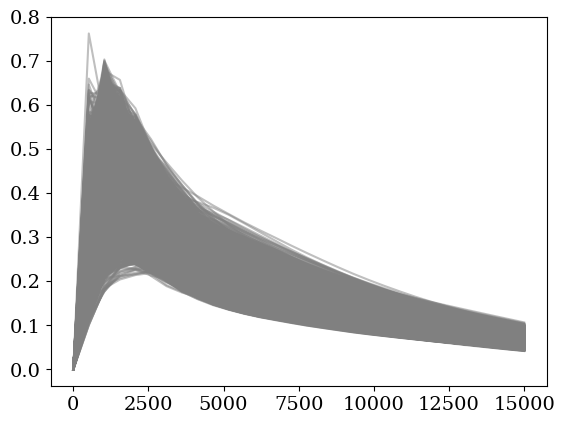

In [146]:
ells = np.linspace(1,15000, 30)
for i in range(y_train.shape[0]):
    plt.plot(ells, nn.scalerY.inverse_transform(y_train[i][None,:]).flatten(), color='gray', alpha=.5)

Prepping data for regresson
Prepped data
(5103, 30) samples
(5103, 5) features
Now running regression...
Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9845 - val_loss: 0.7613
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.6935 - val_loss: 0.3617
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.3410 - val_loss: 0.2371
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.2368 - val_loss: 0.1877
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.1941 - val_loss: 0.1629
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.1660 - val_loss: 0.1470
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 0.1549 - val_loss: 0.1374
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.1359 - val_loss: 0.1292
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.1340 - val_loss: 0.1257
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.1328 - val_loss: 0.1230
Epoch 

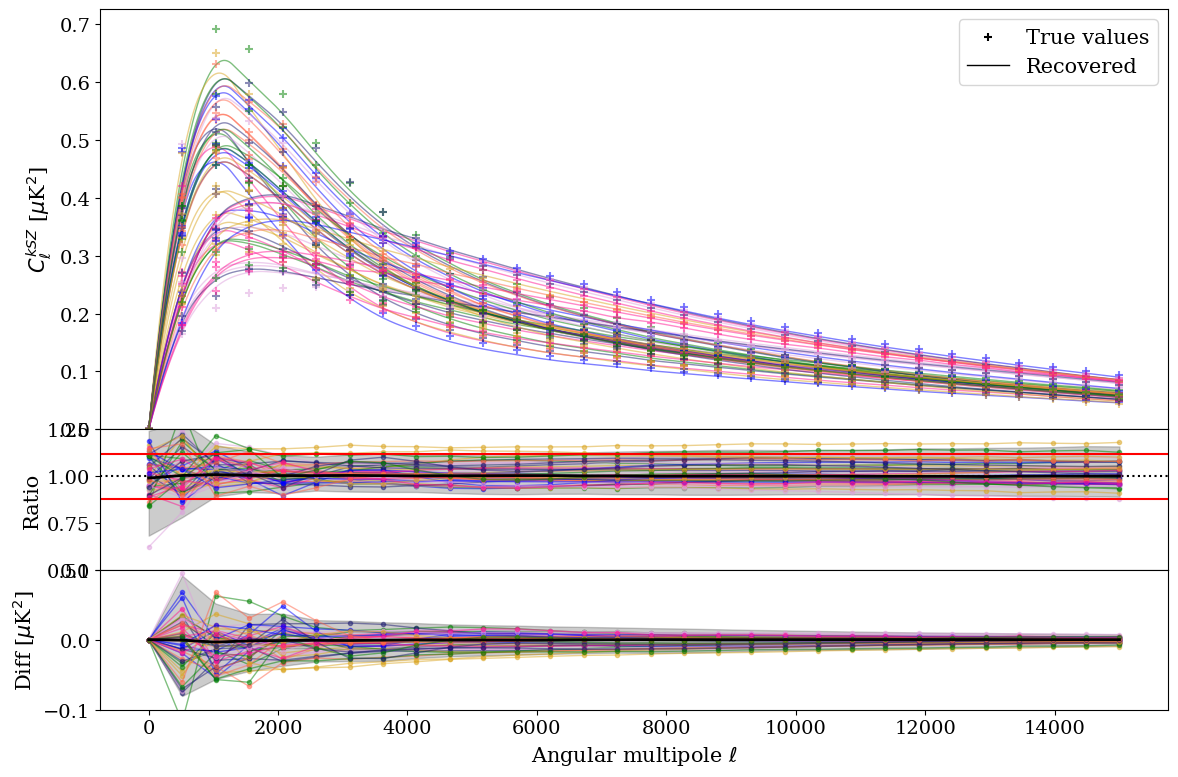

In [141]:
nn = NeuralNetwork(df, {}, params_to_regress, scale_data=True)
X_train, X_test, y_train, y_test = nn.prep_data()
nn.regress(X_train, X_test, y_train, y_test)
y_pred = nn.prediction(X_test)
nn.fancy_plot(y_test, y_pred)

In [152]:
X_train.shape

(4082, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


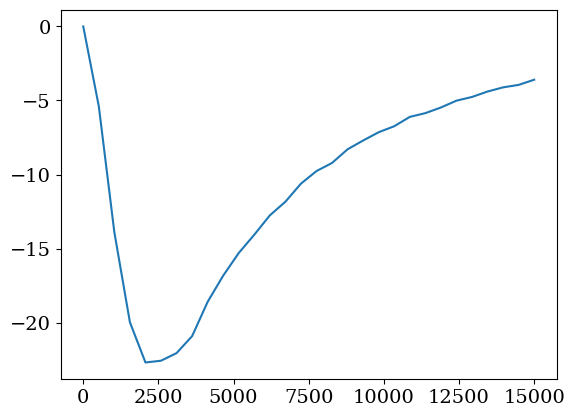

In [139]:
plt.plot(ells, nn.prediction(means[None,:]).flatten())

0.0002 < L_X < 0.0192
with mean L_X=0.0047

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━

Text(0.5, 1.0, 'Neural Network')

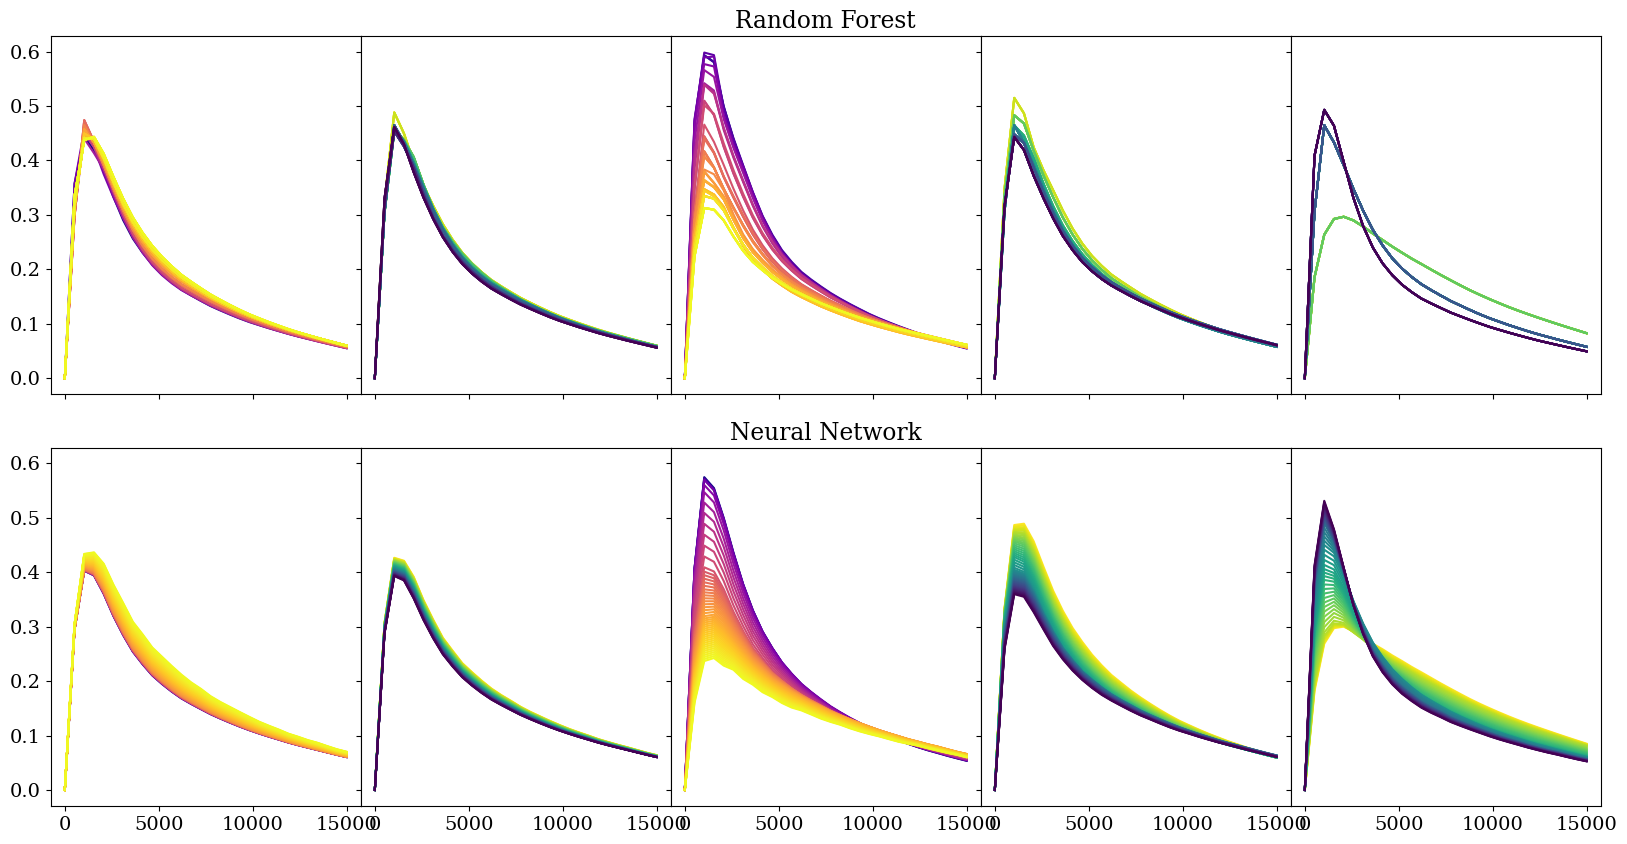

In [163]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.0, hspace=0.15)

means = np.mean(nn.params, axis=0)

for i, pname in enumerate(astro_labels):
    if (pname == params_to_regress[0]) or (pname == params_to_regress[2]):
        norm = matplotlib.colors.LogNorm(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('plasma') 
    else:   
        norm = matplotlib.colors.Normalize(vmin=df[pname].min(), vmax=df[pname].max())
        cmap = plt.get_cmap('viridis_r')
    pvals = nn.params[:,i]
    p = np.linspace(pvals.min(), pvals.max())

    print('%.4f < %s < %.4f' %(np.min(pvals),paramnames[i],np.max(pvals)))
    print(f'with mean {paramnames[i]}={means[i]:.4f}')
    print()

    for j, p in enumerate(p):
        m = cp.deepcopy(means) 
        m[i] = p
        m = m.reshape(1,m.size)
        Y_nn = nn.prediction(nn.scalerX.transform(m)).flatten()
        Y_rf = rf.prediction(rf.scalerX.transform(m)).flatten()

        ax[0,i].plot(ells, Y_rf, color=cmap(norm(p)))
        ax[1,i].plot(ells, Y_nn, color=cmap(norm(p)))

ax[0,2].set_title('Random Forest')
ax[1,2].set_title('Neural Network')

In [102]:
plt.plot(ells, nn.prediction(np.mean(nn.params, axis=0)))

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [100]:
np.mean(nn.params, axis=0)

array([4.71808677e-03, 5.02057613e-01, 3.14894539e+03, 8.78858123e+00,
       2.36155203e-01])

In [64]:
X_train[0]

array([-0.33173916, -0.88129308, -0.05210318, -1.0090183 ,  1.67364109])

Prepping data for regresson
Prepped data
(5103, 30) samples
(5103, 5) features
Performing regression with 5:
	 ['Xray_Lfunc', 'hard_Xray_fraction', 'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post']


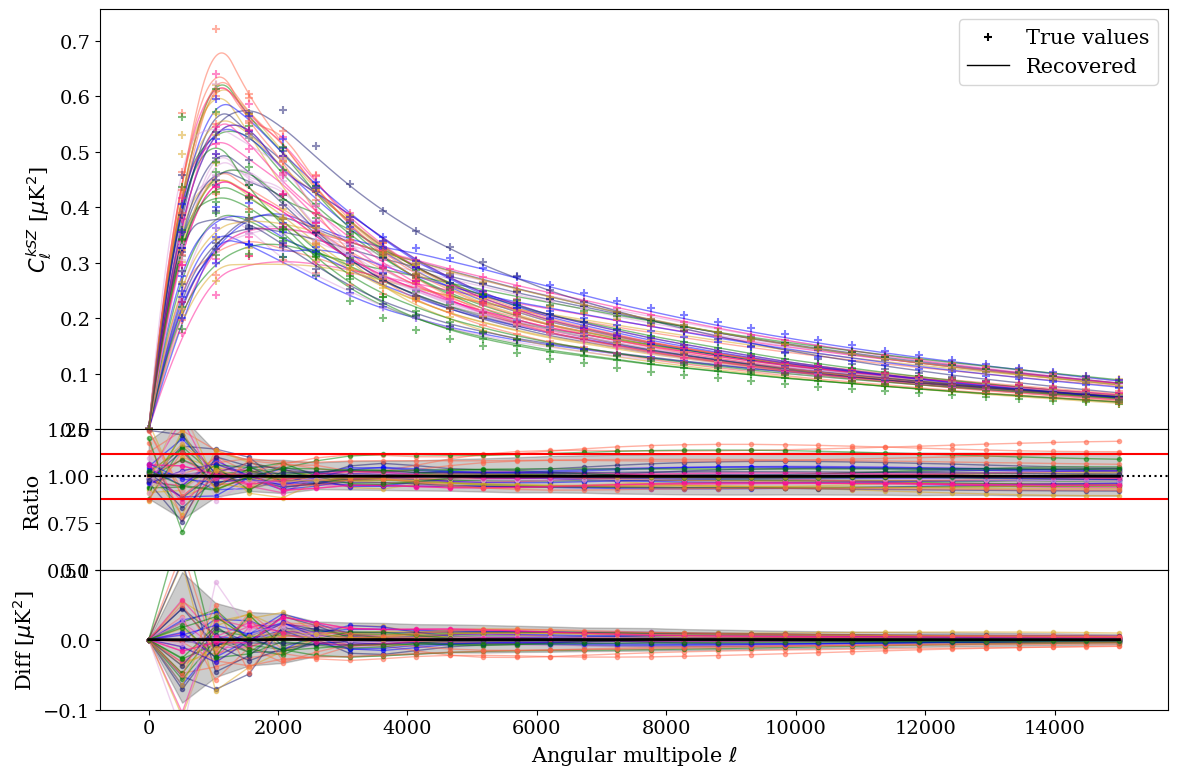

In [154]:
rf = RandomForest(df, {}, params_to_regress)
X_train, X_test, y_train, y_test = rf.prep_data()
rf.regress(X_train, X_test, y_train, y_test)
y_pred = rf.prediction(X_test)
rf.fancy_plot(y_test, y_pred)

In [60]:
np.where(np.isin(params_to_regress, rf.features))[0]

array([0, 1, 2, 3, 4])